# Teste do Algoritmo IForest
Teste dos algoritmos de detecção de anomalias para comparação e seleção dos integrantes do aplicativo

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

tabelafinal = pd.DataFrame(columns=['algoritmo','contaminacao','acuracia','precisao','recall','f1','fn','fp','tp'])
print(tabelafinal)
 
def avalia(clf_name,Y,y_train_scores,y_train_pred):
    # Avalia e imprime os resultados
    print("Avaliação do modelo "+clf_name+":")
    evaluate_print(clf_name, Y, y_train_scores)
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    print('Acurácia='+str(accuracy_score(Y,y_train_pred)*100))   
    print('Precisão='+str(precision_score(Y,y_train_pred)*100))
    print('Recall='+str(recall_score(Y,y_train_pred)*100))
    print('Falso Positivo='+str(fp))
    print('Falso Negativo='+str(fn))
    print('F1-score='+str(f1_score(Y,y_train_pred)*100))
    print('ROC='+str(roc_auc_score(Y,y_train_scores)))

def gera_matriz_de_confusao(Y,y_train_pred,clf_name):
    cm = confusion_matrix(Y,y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Anomalia'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title='Matriz de Confusão do '+clf_name,xlabel='Valores preditos', ylabel='Valores reais')
    plt.show()
    
def grava_avaliacao(clf_name,Y,y_train_scores,y_train_pred,contamination):
    # Grava os resultados da avaliação na tabela final
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    ac=("{:.2f}".format(round(accuracy_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Acurácia='+ac)   
    pc=("{:.2f}".format(round(precision_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Precisão='+pc)
    rc=("{:.2f}".format(round(recall_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Recall='+rc)
    f1=("{:.2f}".format(round(f1_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('F1='+f1)
    print('Falso Negativo='+str(fn))
    print('Falso Positivo='+str(fp))
    print('Verdadeiro Positivo='+str(tp))
    cont=str(round(contamination,2)).replace(".",",")
    tabelafinal.loc[len(tabelafinal.index)] = [clf_name,cont,ac,pc,rc,f1,fn,fp,tp] 
      

Empty DataFrame
Columns: [algoritmo, contaminacao, acuracia, precisao, recall, f1, fn, fp, tp]
Index: []


# Recuperação dos dados a serem utilizados na avaliação
Leitura do arquivo gerado para o material de catmat_id= 445485 -> Descrição:'ÁGUA MINERAL NATURAL, TIPO SEM GÁS MATERIAL EMBALAGEM PLÁSTICO TIPO EMBALAGEM RETORNÁVEL'.

In [2]:
import os
import pandas as pd
def load_itens(path):
    csv_path = os.path.join(path,"445485.csv")
    return pd.read_csv(csv_path)

df=load_itens(".")
## Retira os campos que não serão utilizados no treinamento
df = df.drop(['licitacao_contrato'],axis=1)
df = df.drop(['id'],axis=1)
df = df.drop(['data'],axis=1)
df = df.drop(['catmat_id'],axis=1)
df = df.drop(['unidade'],axis=1)
df = df.drop(['valor_total'],axis=1)
df = df.drop(['municipio_uasg'],axis=1)
df = df.drop(['municipio_fornecedor'],axis=1)
print(df)

     quantidade  valor_unitario  distancia_uasg_fornecedor  anomalia
0           420           12.00                    935.371         0
1         28000            5.88                      0.000         0
2          2100            5.09                      0.000         0
3           360            7.70                    172.788         0
4           120            7.70                    172.788         0
..          ...             ...                        ...       ...
725        5000           10.45                    398.772         0
726        4000           13.45                    398.772         0
727        1440           11.37                      0.000         0
728        1440           10.58                      0.000         0
729          10           20.00                      0.000         0

[730 rows x 4 columns]


# Separação do Label dos dados

In [3]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
print(X)
print(Y)

     quantidade  valor_unitario  distancia_uasg_fornecedor
0           420           12.00                    935.371
1         28000            5.88                      0.000
2          2100            5.09                      0.000
3           360            7.70                    172.788
4           120            7.70                    172.788
..          ...             ...                        ...
725        5000           10.45                    398.772
726        4000           13.45                    398.772
727        1440           11.37                      0.000
728        1440           10.58                      0.000
729          10           20.00                      0.000

[730 rows x 3 columns]
0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    0
728    0
729    0
Name: anomalia, Length: 730, dtype: int64


# Pré-processamento normalização dos dados min-max e robust

In [4]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np

# Cria uma instância do RobustScaler
robust_scaler = RobustScaler()

# Ajusta e transforma os dados com o RobustScaler
X_robust = robust_scaler.fit_transform(X)

# Cria uma instância do MinMaxScaler
minmax_scaler = MinMaxScaler()

# Ajusta e transforma os dados com o MinMaxScaler
X_minmax =  minmax_scaler.fit_transform(X)
X_minmaxrobust =  minmax_scaler.fit_transform(X_robust)



# IForest

In [5]:
# class pyod.models.iforest.IForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, 
# bootstrap=False, n_jobs=1, behaviour='old', random_state=None, verbose=0)

from pyod.models.iforest import IForest

clf = IForest()
clf_name='IForest'

parametros = {'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],
              'n_estimators': [10,20,30,40,50,60,70,80,90,100],
              'random_state': [69],
              'verbose': [1],
              'n_jobs': [-1],
}

grid = GridSearchCV(estimator = clf,          
                param_grid = parametros,  
                scoring = 'recall',           
                cv = 10) 

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.8s remaining:    7.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s rema

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.6s remaining:   32.8s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    4.3s remaining:   39.5s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.8s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.4s remaining:   31.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.9s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.5s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being s

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    4.1s remaining:   37.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.5s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.6s remaining:   33.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.1s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being s

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:4

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklea

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.8s remaining:   34.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 69, 'verbose': 1}
Avaliação do modelo IForest:
IForest ROC:0.9879, precision @ rank n:0.5714
Acurácia=96.98630136986301
Precisão=48.64864864864865
Recall=85.71428571428571
Falso Positivo=19
Falso Negativo=3
F1-score=62.06896551724138
ROC=0.9879105379810599


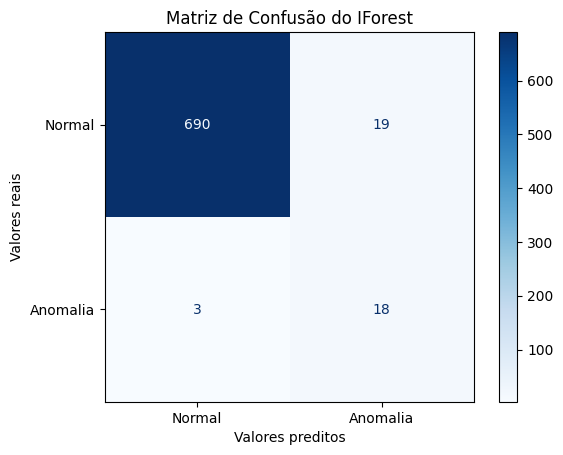

Acurácia=96,99
Precisão=48,65
Recall=85,71
F1=62,07
Falso Negativo=3
Falso Positivo=19
Verdadeiro Positivo=18


In [6]:
# Teste com as duas normalizações

grid_result = grid.fit(X_minmaxrobust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmaxrobust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta e minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.7s remaining:    7.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.1s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s rema

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent work

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent work

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklea

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.3s remaining:   30.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.8s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.8s remaining:   34.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'n_estimators': 40, 'n_jobs': -1, 'random_state': 69, 'verbose': 1}
Avaliação do modelo IForest:
IForest ROC:0.9879, precision @ rank n:0.5714
Acurácia=96.98630136986301
Precisão=48.64864864864865
Recall=85.71428571428571
Falso Positivo=19
Falso Negativo=3
F1-score=62.06896551724138
ROC=0.9879105379810599


[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished


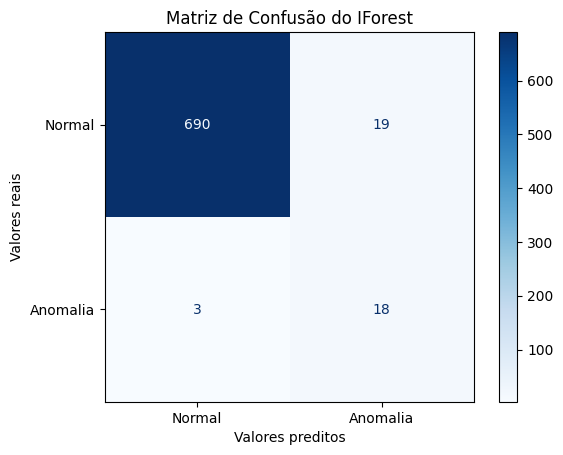

Acurácia=96,99
Precisão=48,65
Recall=85,71
F1=62,07
Falso Negativo=3
Falso Positivo=19
Verdadeiro Positivo=18


In [7]:
# Teste com só MinMax

grid_result = grid.fit(X_minmax, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmax)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.9s remaining:    8.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s rema

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklea

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this b

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s rema

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.3s remaining:   30.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.8s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.7s remaining:   33.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.2s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.5s remaining:   31.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.9s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent work

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklea

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklea

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` param

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    4.1s remaining:   37.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.6s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.4s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_clas

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend w

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 69, 'verbose': 1}
Avaliação do modelo IForest:
IForest ROC:0.9904, precision @ rank n:0.6667
Acurácia=97.26027397260275
Precisão=51.35135135135135
Recall=90.47619047619048
Falso Positivo=18
Falso Negativo=2
F1-score=65.51724137931035
ROC=0.9903955940627309


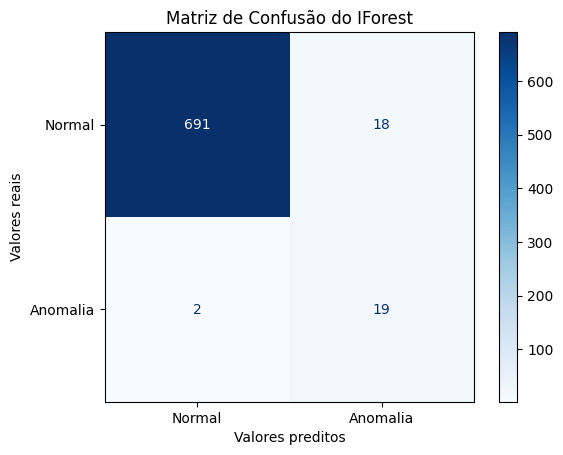

Acurácia=97,26
Precisão=51,35
Recall=90,48
F1=65,52
Falso Negativo=2
Falso Positivo=18
Verdadeiro Positivo=19


In [8]:
# Teste com só Robusta

grid_result = grid.fit(X_robust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_robust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.7s remaining:    7.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.1s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in u

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 |

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.4s remaining:   31.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.9s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.0s remaining:   28.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.5s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.5s remaining:   32.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Rec

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.6s remaining:    6.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.1s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | ela

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.3s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packag

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.2s remaining:   29.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.7s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packag

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.1s remaining:   28.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.6s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packag

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.2s remaining:   30.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.8s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Rec

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.6s remaining:    6.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.1s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | ela

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarni

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Paralle

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    3.4s remaining:   31.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.9s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | ela

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Isolation

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestr

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[P

[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.0s finished
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarni

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 69, 'verbose': 1}
Avaliação do modelo IForest:
IForest ROC:0.9904, precision @ rank n:0.6667
Acurácia=97.26027397260275
Precisão=51.35135135135135
Recall=90.47619047619048
Falso Positivo=18
Falso Negativo=2
F1-score=65.51724137931035
ROC=0.9903955940627309


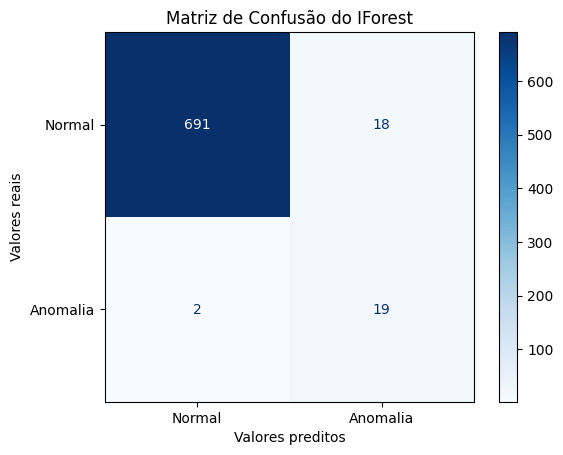

Acurácia=97,26
Precisão=51,35
Recall=90,48
F1=65,52
Falso Negativo=2
Falso Positivo=18
Verdadeiro Positivo=19


In [9]:
# Teste sem Normalização

grid_result = grid.fit(X, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name,Y,clf.decision_scores_,clf.labels_,round(contamination,2))

# Imprime a tabela final de avaliação

In [10]:
tabelafinal.sort_values("fn", axis = 0, ascending = True,
                 inplace = True, na_position ='last')
print(tabelafinal)

                  algoritmo contaminacao acuracia precisao recall     f1  fn  \
2           IForest Robusta         0,05    97,26    51,35  90,48  65,52   2   
3                   IForest         0,05    97,26    51,35  90,48  65,52   2   
0  IForest Robusta e minmax         0,05    96,99    48,65  85,71  62,07   3   
1            IForest minmax         0,05    96,99    48,65  85,71  62,07   3   

   fp  tp  
2  18  19  
3  18  19  
0  19  18  
1  19  18  
